In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report
# !pip install gdown
import zipfile
import gdown
from glob import glob
from PIL import Image
import random
import cv2
!pip install keras-tuner
import keras_tuner as kt
SEED_VALUE = 123
tf.random.set_seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
image_size = (224, 224)
batch_size = 32

In [2]:
file_id = '1_SeSHhTcra6Qk5UxqUg_oyF_JJLGl3ft'
output = 'datasetzip'
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')


Downloading...
From (original): https://drive.google.com/uc?id=1_SeSHhTcra6Qk5UxqUg_oyF_JJLGl3ft
From (redirected): https://drive.google.com/uc?id=1_SeSHhTcra6Qk5UxqUg_oyF_JJLGl3ft&confirm=t&uuid=f0ea9b1a-9a0a-4ed3-9da1-e2590914cdff
To: /content/datasetzip
100%|██████████| 202M/202M [00:04<00:00, 42.2MB/s]


In [4]:
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.15,
    label_mode="categorical",
    subset="training",
    seed=SEED_VALUE,
    image_size=image_size,
    batch_size=batch_size
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.15,
    label_mode="categorical",
    subset="validation",
    seed=SEED_VALUE,
    image_size=image_size,
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size
)


Found 5375 files belonging to 5 classes.
Using 4569 files for training.
Found 5375 files belonging to 5 classes.
Using 806 files for validation.
Found 586 files belonging to 5 classes.


## 2a. Exploratory Data Analysis & Preprocessing

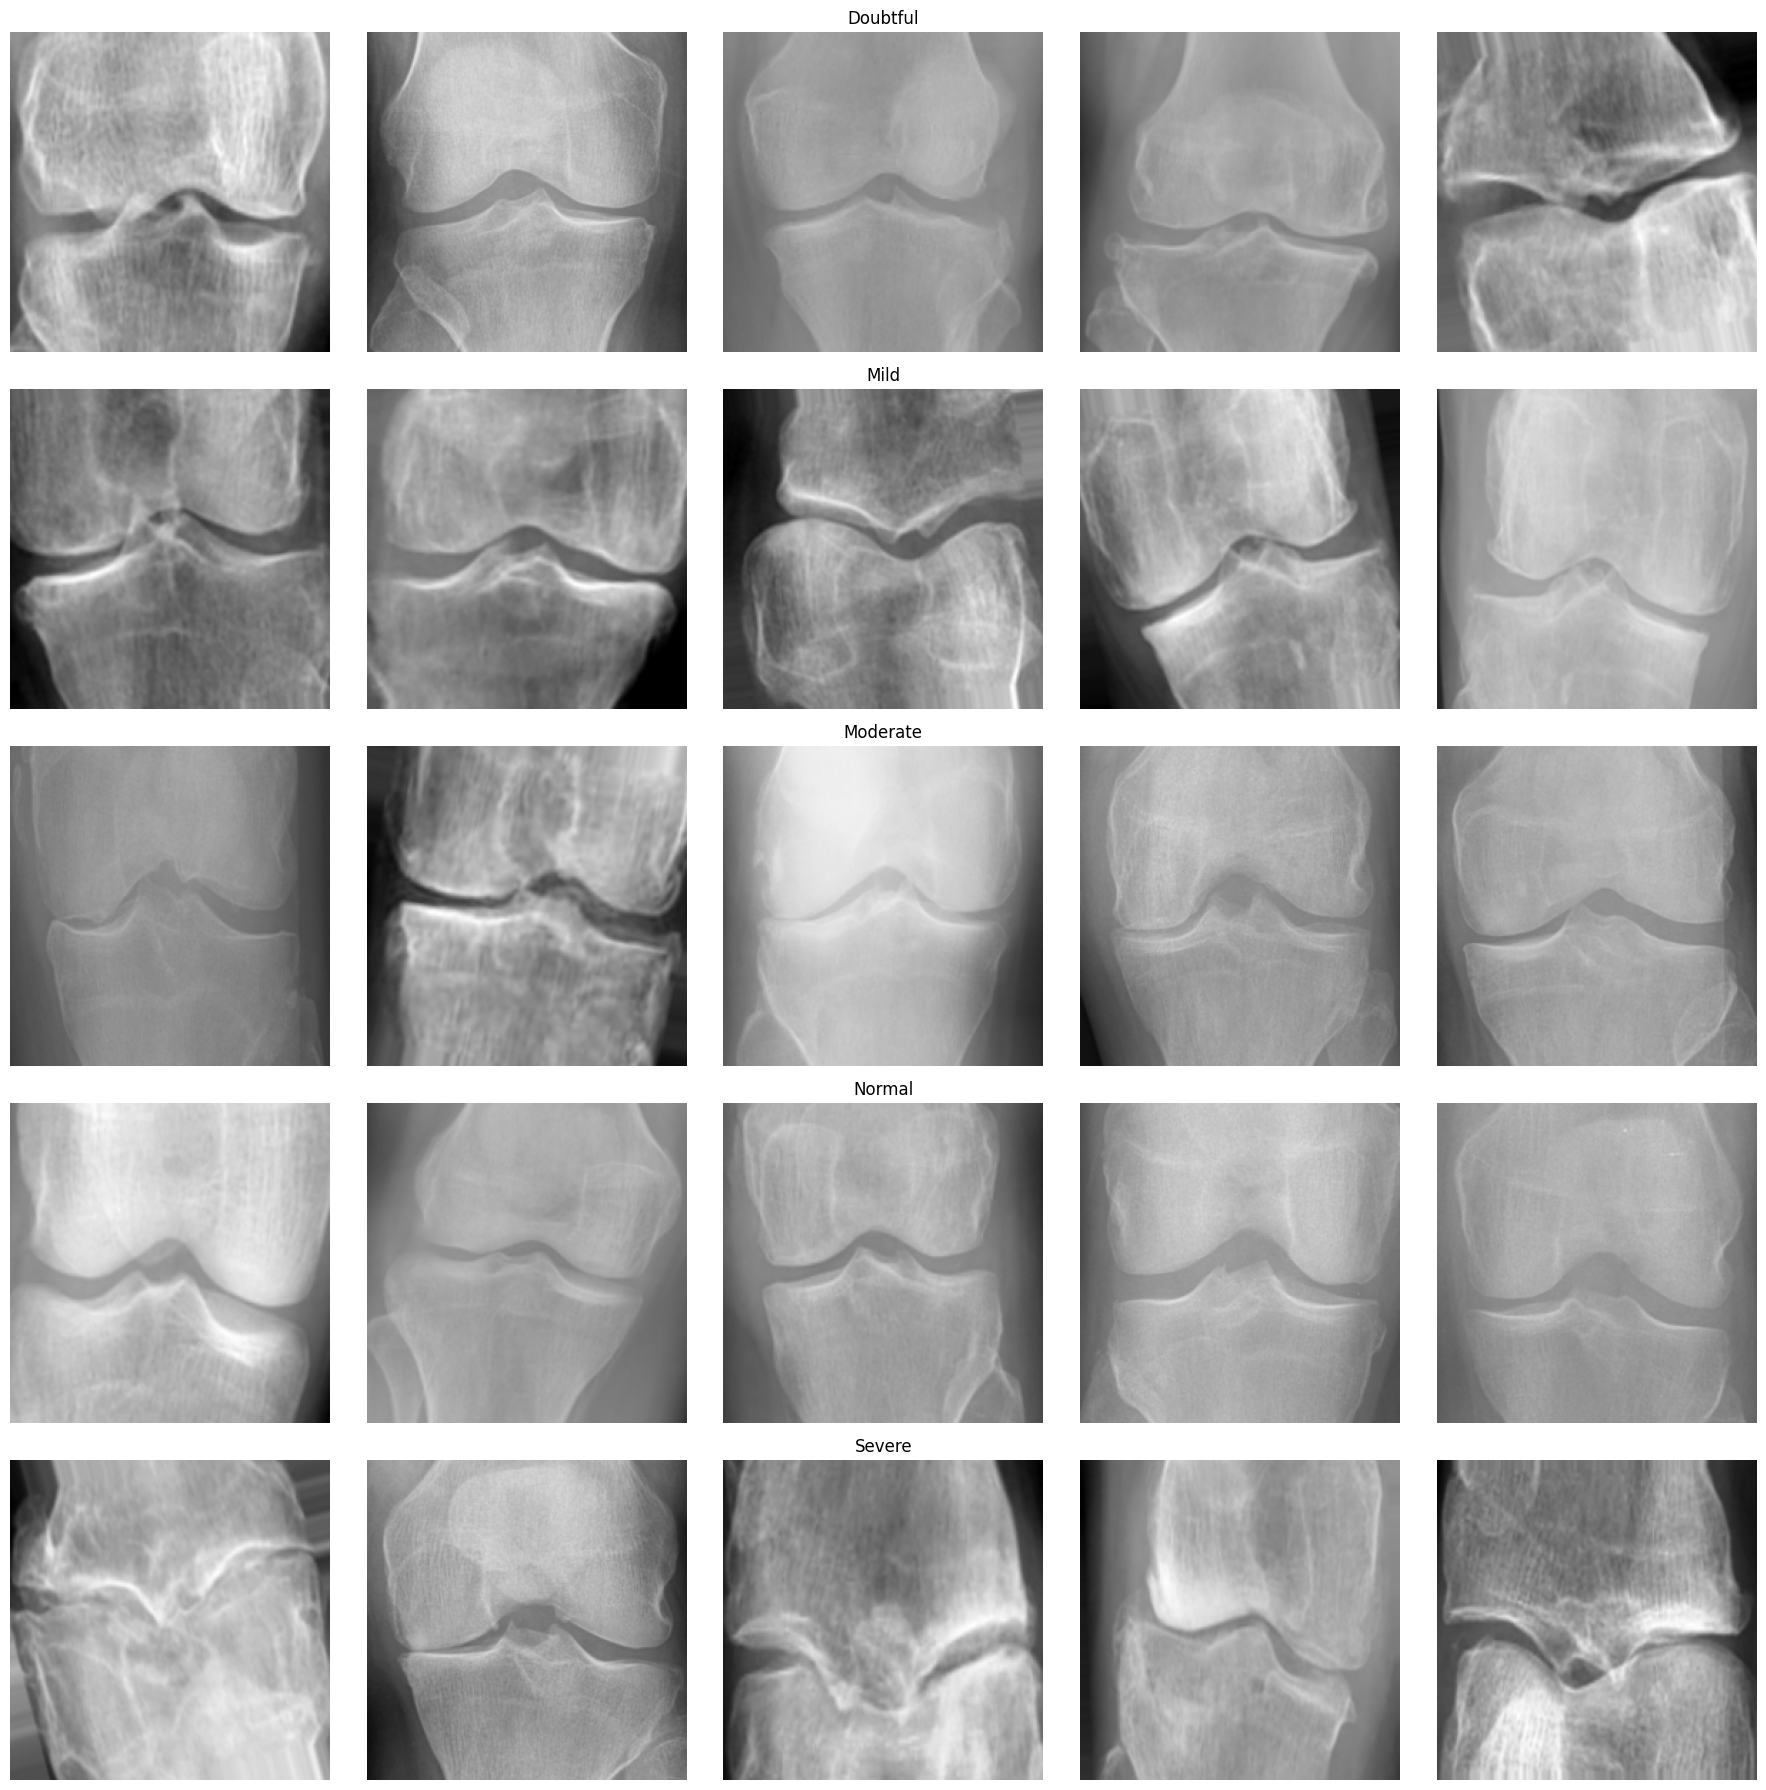

In [5]:
plt.figure(figsize=(18, 18))
for class_id, class_name in enumerate(['Doubtful', 'Mild', 'Moderate', 'Normal', 'Severe']):
    class_path = os.path.join(train_dir, class_name)
    samples = random.sample(os.listdir(class_path), 5)

    for col, sample in enumerate(samples):
        img = cv2.imread(os.path.join(class_path, sample))
        plt.subplot(5, 5, class_id*5 + col + 1)
        plt.imshow(img)
        plt.title(class_name if col == 2 else '')
        plt.axis('off')

plt.tight_layout()
plt.show()

Visualisasi di atas menampilkan contoh gambar dari setiap kelas, yang menunjukkan perbedaan dalam tampilan gambar antarkelas. Dengan melihat ini, kita dapat memeriksa kualitas dan variabilitas dataset, yang akan memandu langkah-langkah preprocessing seperti normalisasi, augmentasi, dan resizing nantinya.

In [12]:
print("Train Dataset Info:")
for images, labels in train_ds.take(1):
    print(f"Shape of images: {images.shape}")

    aspect_ratios = [img.shape[0] / img.shape[1] for img in images]
    print(f"Aspect ratios: {aspect_ratios[:5]}")

Train Dataset Info:
Shape of images: (32, 224, 224, 3)
Aspect ratios: [1.0, 1.0, 1.0, 1.0, 1.0]


Dataset berisi 32 gambar dengan ukuran 224x224 piksel dan 3 saluran warna (RGB). Ini adalah format yang konsisten dan sesuai untuk diproses dalam model CNN, karena ukuran gambar seragam dan dapat diterima oleh model AlexNet yang mengharuskan input berukuran 224x224x3. Kemudian semua gambar dalam dataset ini juga memiliki aspect ratio yang konsisten yaitu 1:1 (lebar = tinggi).

In [8]:
for kelas in os.listdir(train_dir):
    jumlah = len(os.listdir(f"{train_dir}/{kelas}"))
    contoh = os.listdir(f"{train_dir}/{kelas}")[0]
    ukuran = Image.open(f"{train_dir}/{kelas}/{contoh}").size
    print(f"{kelas}: {jumlah} pictures, size: {ukuran}")

Normal: 1055 pictures, size: (224, 224)
Moderate: 1155 pictures, size: (224, 224)
Severe: 1055 pictures, size: (224, 224)
Doubtful: 1055 pictures, size: (224, 224)
Mild: 1055 pictures, size: (224, 224)


In [13]:
for images, labels in train_ds.take(1):
    print(f"Image resolution (height, width): {images.shape[1:3]}")


Image resolution (height, width): (224, 224)


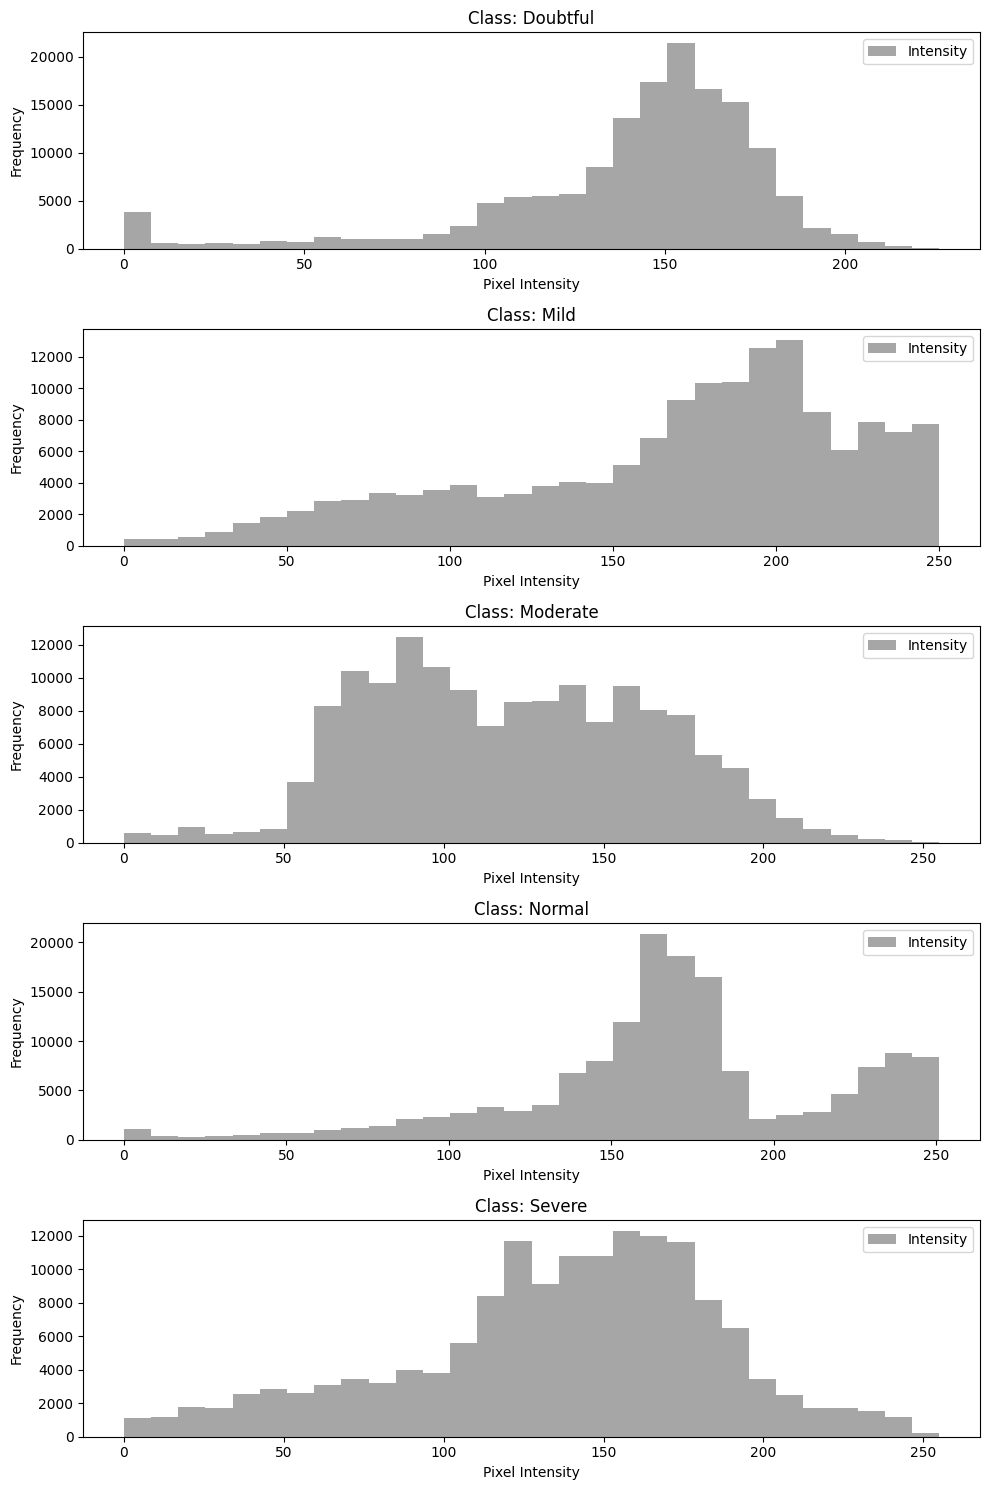

In [14]:
def plot_grayscale_histogram(dataset, num_samples=3):
    class_names = dataset.class_names
    fig, ax = plt.subplots(len(class_names), 1, figsize=(10, 15))

    for i in range(len(class_names)):
        ax[i].set_title(f"Class: {class_names[i]}")

        class_images = []
        for images, labels in dataset:
            for j in range(len(labels)):
                if np.argmax(labels.numpy()[j]) == i:
                    class_images.append(images.numpy()[j])
                    if len(class_images) >= num_samples:
                        break
            if len(class_images) >= num_samples:
                break

        intensity = []

        for img in class_images:
            if img.shape[-1] == 1:
                intensity.extend(img.flatten())
            else:
                avg_intensity = np.mean(img, axis=-1)
                intensity.extend(avg_intensity.flatten())

        ax[i].hist(intensity, bins=30, color='gray', alpha=0.7, label="Intensity")
        ax[i].legend()
        ax[i].set_xlabel("Pixel Intensity")
        ax[i].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

plot_grayscale_histogram(train_ds)


Doubtful: intensitas dominan pada nilai rendah hingga menengah (50–150) yang menunjukkan gambar lebih gelap.

Mild: puncak intensitas sedikit lebih tinggi antara 150–200, menunjukkan gambar yang lebih terang.

Moderate: distribusi lebih merata dengan puncak antara 150–200, menunjukkan variasi pencahayaan.

Normal: intensitas terpusat pada 150–200 yang menandakan gambar dengan pencahayaan baik.

Severe: distribusi mirip dengan "Normal", namun lebih tersebar ke intensitas lebih tinggi.


Analyzing class: Normal


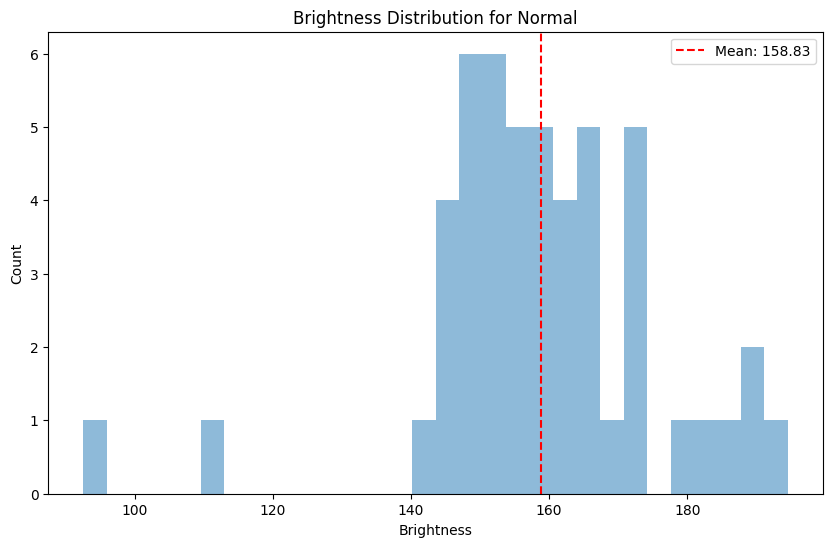

Class: Normal
Brightness range: 92.5 to 194.6
Mean brightness: 158.83
Standard deviation: 17.18
----------------------------------------
Analyzing class: Moderate


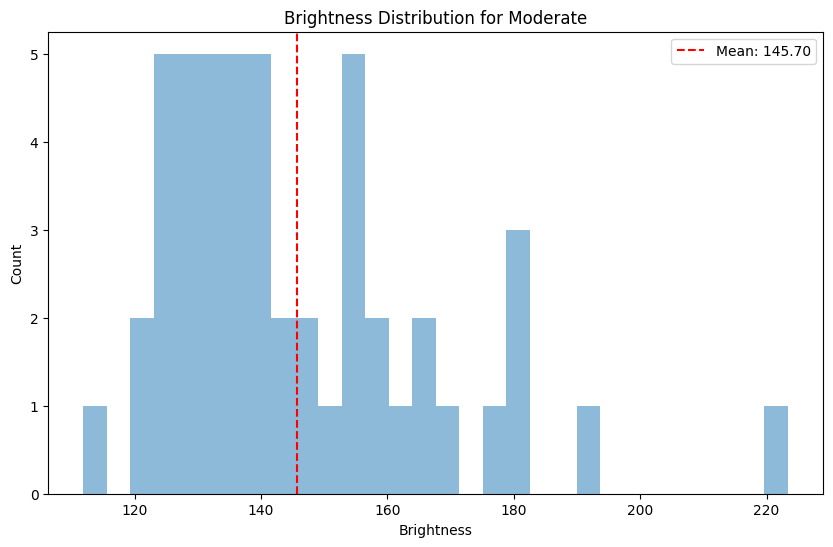

Class: Moderate
Brightness range: 111.9 to 223.4
Mean brightness: 145.70
Standard deviation: 21.33
----------------------------------------
Analyzing class: Severe


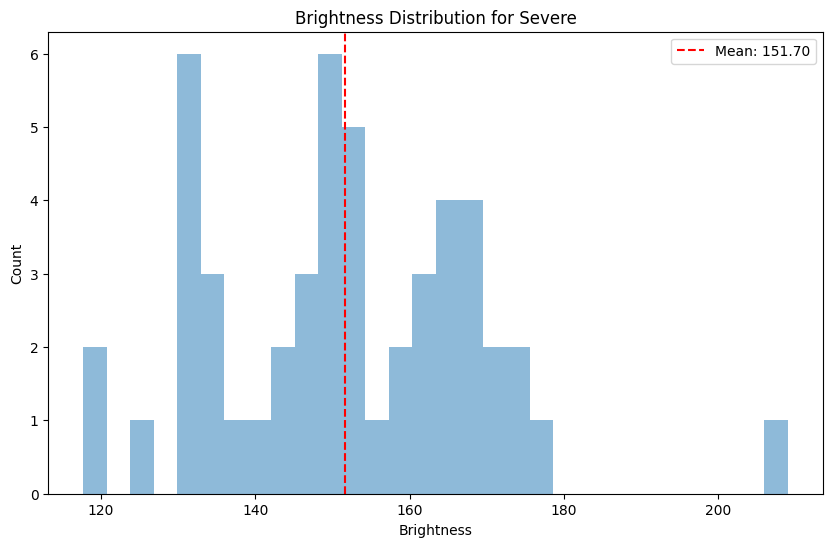

Class: Severe
Brightness range: 117.7 to 209.0
Mean brightness: 151.70
Standard deviation: 17.02
----------------------------------------
Analyzing class: Doubtful


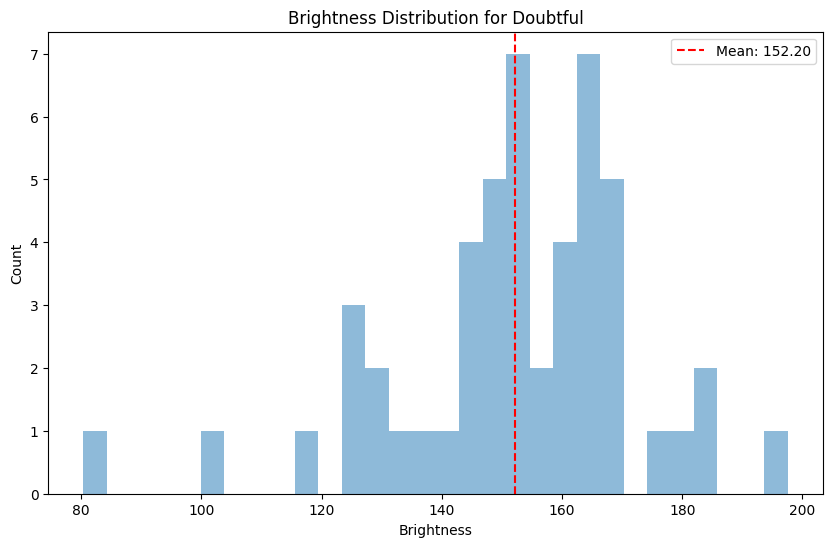

Class: Doubtful
Brightness range: 80.4 to 197.6
Mean brightness: 152.20
Standard deviation: 20.68
----------------------------------------
Analyzing class: Mild


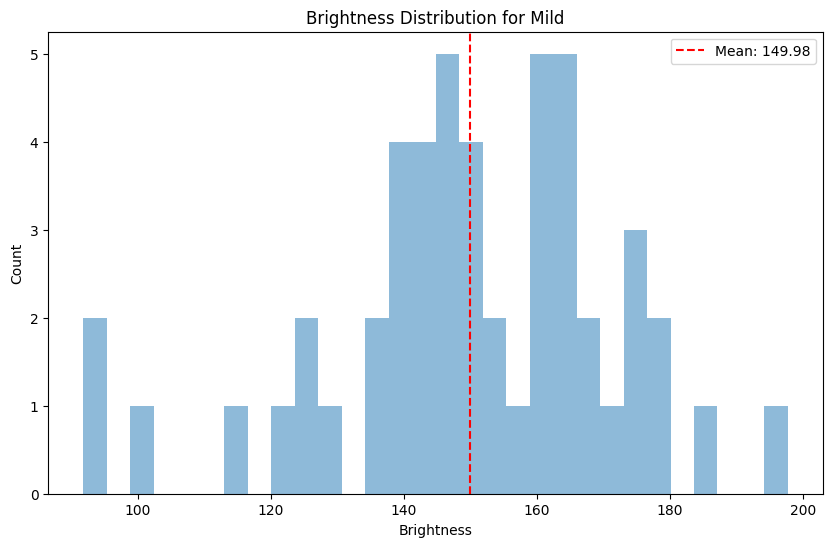

Class: Mild
Brightness range: 91.9 to 197.7
Mean brightness: 149.98
Standard deviation: 21.81
----------------------------------------


In [19]:
def variability(class_folder, label):
    image_paths = glob(os.path.join(class_folder, "*.jpg")) + \
                  glob(os.path.join(class_folder, "*.jpeg")) + \
                  glob(os.path.join(class_folder, "*.png"))

    sample_size = 50
    selected_images = np.random.choice(image_paths, min(sample_size, len(image_paths)), replace=False)
    brightness_vals = []

    for img_path in selected_images:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        brightness_vals.append(np.mean(img))

    plt.figure(figsize=(10, 6))
    plt.hist(brightness_vals, bins=30, alpha=0.5)
    plt.axvline(np.mean(brightness_vals), color='red', linestyle='--', label=f'Mean: {np.mean(brightness_vals):.2f}')
    plt.title(f'Brightness Distribution for {label}')
    plt.xlabel('Brightness')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

    print(f"Class: {label}")
    print(f"Brightness range: {min(brightness_vals):.1f} to {max(brightness_vals):.1f}")
    print(f"Mean brightness: {np.mean(brightness_vals):.2f}")
    print(f"Standard deviation: {np.std(brightness_vals):.2f}")
    print("-" * 40)

dataset_path = '/content/dataset/train'
class_names = os.listdir(dataset_path)

for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    print(f"Analyzing class: {class_name}")
    variability(class_path, class_name)

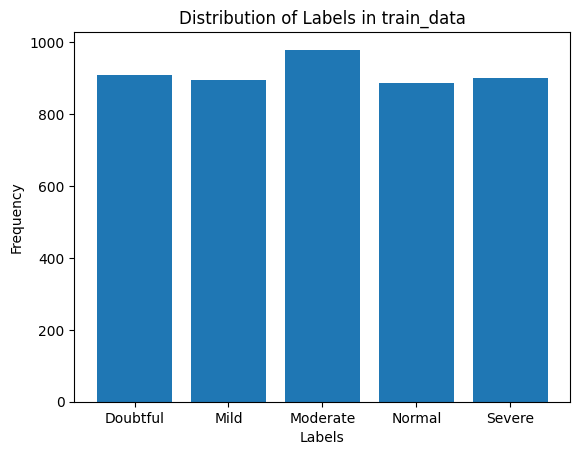

In [21]:
class_names = train_ds.class_names

labels = []
for images, label_batch in train_ds:
    labels.extend(np.argmax(label_batch, axis=-1))

unique, counts = np.unique(labels, return_counts=True)


plt.bar(unique, counts)
plt.xticks(unique, class_names)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in train_data')
plt.show()


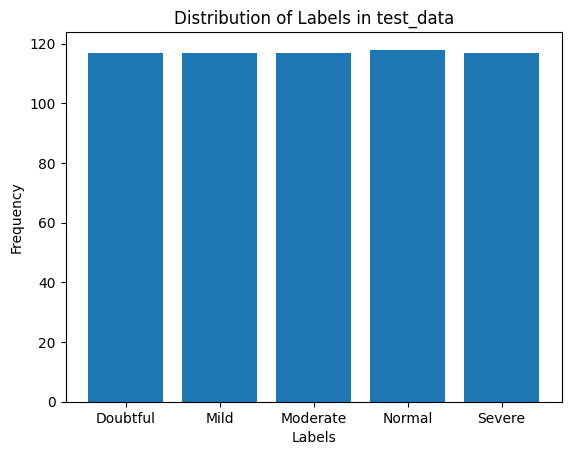

In [10]:
class_names = test_ds.class_names

labels = []
for images, label_batch in test_ds:
    labels.extend(np.argmax(label_batch, axis=-1))
unique, counts = np.unique(labels, return_counts=True)

plt.bar(unique, counts)
plt.xticks(unique, class_names)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in test_data')
plt.show()


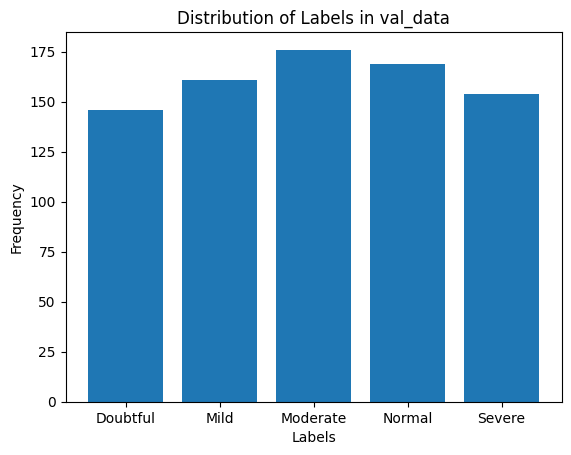

In [11]:
class_names = val_ds.class_names

labels = []
for images, label_batch in val_ds:
    labels.extend(np.argmax(label_batch, axis=-1))
unique, counts = np.unique(labels, return_counts=True)

plt.bar(unique, counts)
plt.xticks(unique, class_names)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in val_data')
plt.show()


In [12]:
def train_augmentation(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    image = tf.image.per_image_standardization(image)
    return image, label

def augment_images(image, label):
    image = tf.image.per_image_standardization(image)
    return image, label



1.   Random Flip: gambar dibalik secara random secara horizontal untuk membantu model mengenali objek dari berbagai posisi.
2.  Random Contrast: meningkatkan variasi pencahayaan dengan mengubah kontras gambar secara random dalam rentang 0.7 hingga 1.3. Tujuannya agar model lebih tahan terhadap perbedaan pencahayaan pada gambar.
3. Image Standardization: standarisasi menggunakan tf.image.per_image_standardization, yang mengubah setiap gambar agar memiliki nilai rata-rata 0 dan standar deviasi 1, yang berguna untuk mempercepat konvergensi model.

In [13]:
train_ds = train_ds.map(train_augmentation)
val_ds = val_ds.map(augment_images)
test_ds = test_ds.map(augment_images)


## 2b.Baseline Model

In [14]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
    keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),

    keras.layers.Conv2D(filters=256, kernel_size=(5,5), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),

    keras.layers.Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu'),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),


    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.compile(optimizer='adam',loss='categorical_crossentropy',  metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │        20,485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,767,493 (178.40 MB)

 Trainable params: 46,767,493 (178.40 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10, batch_size=32)


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 150ms/step - accuracy: 0.2053 - loss: 2.5492 - val_accuracy: 0.2184 - val_loss: 1.6108
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 109ms/step - accuracy: 0.2001 - loss: 1.6105 - val_accuracy: 0.2184 - val_loss: 1.6098
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.2082 - loss: 1.6102 - val_accuracy: 0.2184 - val_loss: 1.6098
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.2120 - loss: 1.6095 - val_accuracy: 0.2184 - val_loss: 1.6094
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.2085 - loss: 1.6094 - val_accuracy: 0.2184 - val_loss: 1.6097
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.2138 - loss: 1.6093 - val_accuracy: 0.2184 - val_loss: 1.6096
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.2127 - loss: 1.6095 - val_accuracy: 0.2184 - val_loss: 1.6093
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - accuracy: 0.2111 - loss: 1.6098 

In [17]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.2106 - loss: 1.6107
Test Loss: 1.610284686088562
Test Accuracy: 0.19965870678424835


In [18]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(tf.argmax(labels, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

print(classification_report(y_true, y_pred, target_names=[
    'Doubtful', 'Mild', 'Moderate', 'Normal', 'Severe'
]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
              precision    recall  f1-score   support

    Doubtful       0.00      0.00      0.00       117
        Mild       0.00      0.00      0.00       117
    Moderate       0.20      1.00      0.33       117
      Normal       0.00      0.00      0.00       118
     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 2c. Modifikasi dan Fine tuning

In [19]:
epochs = 50
learning_rate = 1e-4
fine_tune_learning_rate = 1e-5
batch_size = 32

model2 = keras.models.Sequential([
    layers.Conv2D(filters=128, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(filters=384, kernel_size=(5, 5), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.BatchNormalization(),

    layers.Flatten(),

    layers.Dense(4096, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(2048, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(1024, activation='relu'),
    layers.Dense(5, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 54, 54, 128)    │        46,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 384)    │     1,229,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 12, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 512)    │     1,769,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 5, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    52,432,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,720,901 (269.78 MB)

 Trainable params: 70,706,565 (269.72 MB)

 Non-trainable params: 14,336 (56.00 KB)

Pada bagian ini, saya menggunakan learning rate scheduler bernama ReduceLROnPlateau yang bertujuan untuk mengurangi learning rate secara otomatis saat model tidak mengalami perbaikan pada validation loss.

In [21]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=fine_tune_learning_rate)
history2 = model2.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size, callbacks=[lr_scheduler])


Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 43s 197ms/step - accuracy: 0.2953 - loss: 1.9458 - val_accuracy: 0.2792 - val_loss: 1.7376 - learning_rate: 1.0000e-04
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.3586 - loss: 1.7120 - val_accuracy: 0.2854 - val_loss: 1.8042 - learning_rate: 1.0000e-04
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 100ms/step - accuracy: 0.4239 - loss: 1.5083 - val_accuracy: 0.2965 - val_loss: 2.8121 - learning_rate: 1.0000e-04
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.4476 - loss: 1.4302 - val_accuracy: 0.3065 - val_loss: 2.7176 - learning_rate: 1.0000e-04
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.5199 - loss: 1.1874 - val_accuracy: 0.5819 - val_loss: 0.9768 - learning_rate: 5.0000e-05
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.5360 - loss: 1.1461 - val_accuracy: 0.5769 - val_loss: 1.0315 - learning_rate: 5.0000e-05
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/s

In [22]:
test_loss2, test_accuracy2 = model2.evaluate(test_ds)
print(f"Test Loss: {test_loss2}")
print(f"Test Accuracy: {test_accuracy2}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.6466 - loss: 1.5122
Test Loss: 1.4365272521972656
Test Accuracy: 0.6365187764167786


In [25]:
epochs = 50
batch_size = 32
max_trials = 10

def build_model(hp):
    model = keras.models.Sequential([

        layers.Conv2D(filters=hp.Int('conv_1_filters', min_value=128, max_value=256, step=64), kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        layers.BatchNormalization(),

        layers.Conv2D(filters=hp.Int('conv_2_filters', min_value=256, max_value=512, step=128),kernel_size=(5, 5), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        layers.BatchNormalization(),

        layers.Conv2D(filters=hp.Int('conv_3_filters', min_value=384, max_value=512, step=128), kernel_size=(3, 3), padding='same', activation='relu'),
        layers.Conv2D(filters=hp.Int('conv_4_filters', min_value=384, max_value=512, step=128),kernel_size=(3, 3), padding='same', activation='relu'),
        layers.Conv2D(filters=hp.Int('conv_5_filters', min_value=256, max_value=512, step=128),kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        layers.BatchNormalization(),

        layers.Flatten(),

        layers.Dense(hp.Int('dense_1_units', min_value=1024, max_value=4096, step=1024), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(hp.Float('dropout_1', min_value=0.3, max_value=0.5, step=0.1)),

        layers.Dense(hp.Int('dense_2_units', min_value=512, max_value=2048, step=512), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(hp.Float('dropout_2', min_value=0.3, max_value=0.5, step=0.1)),

        layers.Dense(5, activation='softmax')
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-4, 1e-5])),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    return model


tuner = kt.RandomSearch(build_model, objective='val_accuracy', max_trials=max_trials,  executions_per_trial=1, directory='my_dir',  project_name='alexnet_tuning')
tuner.search(train_ds, validation_data=val_ds, epochs=5, batch_size=batch_size)
best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 02m 10s]
val_accuracy: 0.4565756916999817

Best val_accuracy So Far: 0.555831253528595
Total elapsed time: 00h 21m 07s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [26]:
history3 = best_model.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=batch_size)

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 129ms/step - accuracy: 0.4920 - loss: 1.3972 - val_accuracy: 0.4578 - val_loss: 1.9156
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 92ms/step - accuracy: 0.5195 - loss: 1.2628 - val_accuracy: 0.4752 - val_loss: 1.5547
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.5466 - loss: 1.2282 - val_accuracy: 0.5459 - val_loss: 1.5048
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - accuracy: 0.5747 - loss: 1.1058 - val_accuracy: 0.5831 - val_loss: 1.0886
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.6186 - loss: 1.0152 - val_accuracy: 0.6390 - val_loss: 0.9321
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.6386 - loss: 0.9197 - val_accuracy: 0.6638 - val_loss: 0.8794
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - accuracy: 0.6595 - loss: 0.8897 - val_accuracy: 0.6017 - val_loss: 1.0455
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.6742 - loss: 0.8707 

In [27]:

test_loss3, test_accuracy3 = best_model.evaluate(test_ds)
print(f"Test Loss: {test_loss3}")
print(f"Test Accuracy: {test_accuracy3}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5692 - loss: 2.5505
Test Loss: 2.4451088905334473
Test Accuracy: 0.585324227809906


## 2d. Evaluation

Untuk melakukan evaluasi, saya memilih 4 metrik
1. Accuracy: Mengukur persentase prediksi yang benar dari total data yang diprediksi. Metrik ini cocok untuk dataset seimbang, namun kurang informatif pada dataset tidak seimbang.
2. Precision: Mengukur seberapa banyak prediksi positif yang benar dari seluruh prediksi positif. Berguna untuk meminimalkan false positives, misalnya dalam diagnosis medis.
3. Recall: Mengukur seberapa banyak instance positif yang terdeteksi oleh model. Penting untuk meminimalkan false negatives, seperti dalam deteksi penyakit.
4. F1-Score: Rata-rata harmonis antara precision dan recall, memberikan keseimbangan di antara keduanya. Metrik ini sangat berguna untuk dataset yang tidak seimbang.

In [28]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(tf.argmax(labels, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

print(classification_report(y_true, y_pred, target_names=[
    'Doubtful', 'Mild', 'Moderate', 'Normal', 'Severe'
]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
              precision    recall  f1-score   support

    Doubtful       0.00      0.00      0.00       117
        Mild       0.00      0.00      0.00       117
    Moderate       0.20      1.00      0.33       117
      Normal       0.00      0.00      0.00       118
      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1. Accuracy: Model menghasilkan akurasi sekitar 20%, yang menunjukkan bahwa model tidak mampu mengenali pola dengan baik pada data uji. Ini menandakan bahwa model mungkin perlu optimasi lebih lanjut pada arsitekturnya, termasuk pengaturan hyperparameter dan augmentasi data.
2. Precision: Precision model juga sangat rendah, mendekati 0%. Hal ini berarti model menghasilkan banyak false positives, atau prediksi yang salah untuk kelas tertentu, yang menunjukkan ketidakmampuan model untuk meminimalkan kesalahan prediksi pada kelas yang telah dipilih.
3. Recall: Recall model juga rendah, hampir mendekati 0%. Ini menunjukkan bahwa model gagal mendeteksi banyak instance dari kelas yang benar, yang berarti model tidak sensitif terhadap kelas tertentu dan melewatkan banyak prediksi yang benar.
4. F1-Score: F1-Score model juga rendah, hampir 0. Ini menunjukkan bahwa model tidak mencapai keseimbangan yang baik antara precision dan recall, dan secara keseluruhan memiliki performa yang buruk pada dataset ini.

Untuk kelas Moderate, model menunjukkan precision sebesar 0.20, yang berarti dari semua prediksi untuk kelas ini, hanya 20% yang benar-benar termasuk dalam kategori ini. Namun, recall-ya 1.00 yang berarti model berhasil mendeteksi seluruh instance dari kelas Moderate dengan sempurna. Meskipun recall-nya tinggi, precision yang rendah menunjukkan bahwa model cenderung membuat banyak kesalahan pada kelas ini (false positives).

In [30]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds2 = model2.predict(images)
    y_true.extend(tf.argmax(labels, axis=1).numpy())
    y_pred.extend(tf.argmax(preds2, axis=1).numpy())

print(classification_report(y_true, y_pred, target_names=[
    'Doubtful', 'Mild', 'Moderate', 'Normal', 'Severe'
]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
              precision    recall  f1-score   support

    Doubtful       0.47      0.34      0.40       117
        Mild       0.50      0.90      0.65       117
    Moderate       0.69      0.83      0.75       117
      Normal       0.58      0.12      0.20     

1. Accuracy: Model ini berhasil mencapai akurasi 64%. Artinya, dari semua prediksi yang dibuat oleh model, sekitar 64% di antaranya benar. Ini menunjukkan peningkatan signifikan dibandingkan model sebelumnya (baseline) yang hanya mencapai akurasi sekitar 20%.

2. Precision, Recall, dan F1-Score untuk setiap kelas:

- Doubtful: Precision sebesar 0.47 menunjukkan bahwa model berhasil memprediksi 47% dari semua prediksi kelas Doubtful dengan benar. Namun, recall yang hanya 0.34 menunjukkan bahwa model gagal mendeteksi 66% dari semua instance yang benar-benar termasuk dalam kelas ini. F1-score sebesar 0.40 menunjukkan bahwa model masih perlu perbaikan dalam mendeteksi kelas ini.

- Mild: Precision 0.50 berarti model hanya bisa memprediksi 50% prediksi untuk kelas Mild dengan benar, sedangkan recall yang tinggi 0.90 menunjukkan bahwa model berhasil mendeteksi sebagian besar instance dari kelas ini dengan baik. F1-score 0.65 menunjukkan keseimbangan antara precision dan recall yang cukup baik.

- Moderate: Precision 0.69 dan recall 0.83 menunjukkan model cukup baik dalam mendeteksi kelas Moderate, dengan F1-score 0.75 yang menunjukkan keseimbangan yang lebih baik antara precision dan recall.

- Normal: Precision 0.58 dan recall 0.12 menunjukkan masalah serius di kelas Normal, di mana model berhasil memprediksi 58% dari prediksi kelas ini dengan benar, tetapi hanya mendeteksi 12% dari semua instance kelas ini dengan benar. F1-score yang rendah (0.20) mengindikasikan kinerja model yang buruk di kelas ini.

- Severe: Precision yang sangat tinggi (0.91) dan recall yang sempurna (1.00) menunjukkan bahwa model sangat baik dalam mengenali kelas Severe dengan benar tanpa ada kesalahan prediksi. F1-score 0.95 juga menunjukkan kinerja yang sangat baik di kelas ini.



In [32]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds3 = best_model.predict(images)
    y_true.extend(tf.argmax(labels, axis=1).numpy())
    y_pred.extend(tf.argmax(preds3, axis=1).numpy())

print(classification_report(y_true, y_pred, target_names=[
    'Doubtful', 'Mild', 'Moderate', 'Normal', 'Severe'
]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step
              precision    recall  f1-score   support

    Doubtful       0.41      0.17      0.24       117
        Mild       0.66      0.78      0.71       117
    Moderate       0.42      0.85      0.56       117
      Normal       0.65      0.14      0.24       1

1. Accuracy: Model ini berhasil mencapai akurasi sebesar 59%. Angka ini menunjukkan bahwa model dapat memprediksi sekitar 59% dari total data dengan benar.

2. Precision, Recall, dan F1-Score untuk setiap kelas:
- Doubtful: Precision sebesar 0.41 dan recall 0.17 menunjukkan bahwa model gagal mendeteksi sebagian besar instance dari kelas Doubtful, dengan F1-score yang sangat rendah (0.24).
- Mild: Precision 0.66 dan recall 0.78 menunjukkan bahwa model cukup baik dalam mendeteksi kelas Mild, dengan F1-score 0.71 yang menunjukkan keseimbangan yang lebih baik antara precision dan recall.
- Moderate: Precision 0.42 dan recall 0.85 menunjukkan bahwa meskipun precision rendah, recall cukup tinggi, artinya model berhasil mendeteksi banyak instance dari kelas Moderate. F1-score 0.56 menandakan adanya peningkatan antara precision dan recall.
- Normal: Precision 0.65 dan recall 0.14 menunjukkan bahwa meskipun precision baik, recall sangat rendah, artinya model gagal mendeteksi banyak instance kelas ini. F1-score yang rendah (0.24) mengindikasikan kesulitan model dalam mendeteksi kelas ini.
- Severe: Precision 0.86 dan recall 0.98 menunjukkan bahwa model sangat baik dalam mengenali kelas Severe, dengan kesalahan yang minim. F1-score 0.92 menandakan kinerja optimal di kelas ini.